## 1.

Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set. Hint: the ``KNeighborsClassifier`` works quite well for this task; you just need to find good hyperparameter values (try a grid search on the ``weights`` and ``n_neighbors`` hyperparameters).

In [1]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.])}

In [2]:
X, y = mnist["data"], mnist["target"]

In [3]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [4]:
import numpy as np
shuffle_index = np.random.permutation(60000)
shuffle_index
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

param_grid = [
    {"weights": ["uniform", "distance"], "n_neighbors": [3, 4, 5]}
]

# WARNING: Doing a grid search will take 23 hours
# knn_clf = KNeighborsClassifier()
# grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3, n_jobs=-1)
# grid_search.fit(X_train, y_train)

# best_params:
# { "n_neighbors": 4, "weights": "distance }

In [6]:
knn_clf = KNeighborsClassifier(n_neighbors=4, weights="distance")
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='distance')

In [7]:
from sklearn.metrics import accuracy_score

y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9714

## 2.

Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel. Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set. You should observe that your model performs even better now! This technique of artificially growing the training set is called _data augmentation_ or _training set expansion_.

In [8]:
from scipy.ndimage.interpolation import shift

def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

Plot images to verify ``shift_image()`` works:

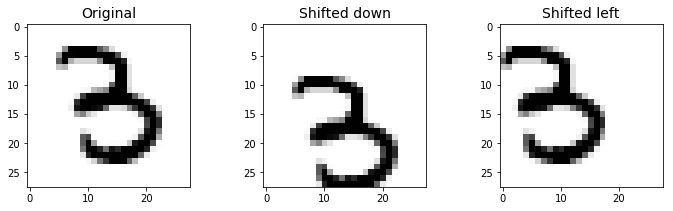

In [9]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 3))

def add_subplot(position, title, img):
    plt.subplot(position)
    plt.title(title, fontsize=14)
    plt.imshow(img.reshape(28, 28), interpolation="nearest", cmap="Greys")

add_subplot(131, "Original", image)
add_subplot(132, "Shifted down", shifted_image_down)
add_subplot(133, "Shifted left", shifted_image_left)
plt.show()

Augment shifted images to training data:

In [10]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)
        
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

Train MNIST classifier in Problem #1 on the augmented dataset:

In [11]:
# shuffle indexes first to avoid sequential data
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [14]:
knn_clf = KNeighborsClassifier(n_neighbors=4, weights="distance", n_jobs=-1)
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
           weights='distance')

In [18]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9763